In [1]:
import os
import re
from pathlib import Path

import anndata
import pandas as pd
import scanpy as sc
import sklearn
import scipy
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors

In [2]:
# !pip install git+https://github.com/estorrs/mgitools

In [3]:
# !pip install scanpy==1.9.1

In [4]:
from wombat.utils import listfiles

In [5]:
output_dir = '/storage1/fs1/dinglab/Active/Projects/estorrs/SpiceMix/analysis/sc_pdac/HT242P1-H1/inputs/files'
Path(output_dir).mkdir(parents=True, exist_ok=True)

In [6]:
fps = sorted(listfiles('/storage1/fs1/dinglab/Active/Projects/Datasets/spatial_transcriptomics/cellranger_outs/pdac/',
                       regex=r'outs/filtered_feature_bc_matrix.h5$'))
fps = [fp for fp in fps if 'CRISPR' not in fp]
fps = [fp for fp in fps if '242P1' in fp]
len(fps), fps

(4,
 ['/storage1/fs1/dinglab/Active/Projects/Datasets/spatial_transcriptomics/cellranger_outs/pdac/PDAC_242P1/PDAC_242P1-H1/outs/filtered_feature_bc_matrix.h5',
  '/storage1/fs1/dinglab/Active/Projects/Datasets/spatial_transcriptomics/cellranger_outs/pdac/PDAC_242P1/PDAC_242P1-H2A2/outs/filtered_feature_bc_matrix.h5',
  '/storage1/fs1/dinglab/Active/Projects/Datasets/spatial_transcriptomics/cellranger_outs/pdac/PDAC_242P1/PDAC_242P1-H3/outs/filtered_feature_bc_matrix.h5',
  '/storage1/fs1/dinglab/Active/Projects/Datasets/spatial_transcriptomics/cellranger_outs/pdac/PDAC_242P1/PDAC_242P1-H4A2/outs/filtered_feature_bc_matrix.h5'])

PDAC_242P1-H1


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/miniconda/envs/SpiceMix/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


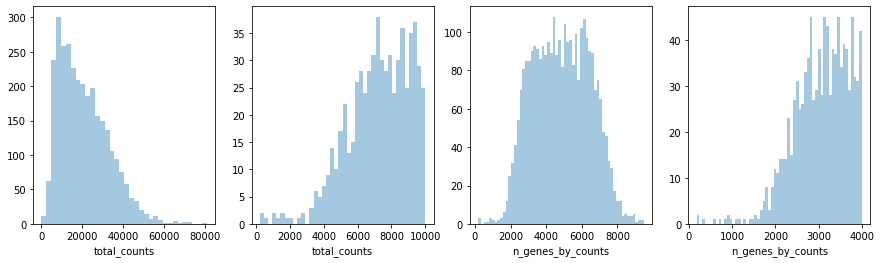

PDAC_242P1-H2A2


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


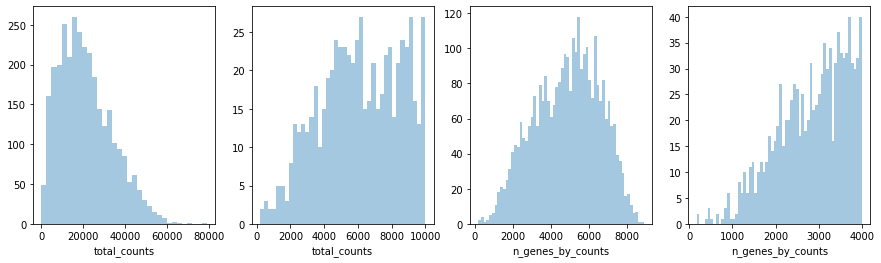

PDAC_242P1-H3


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


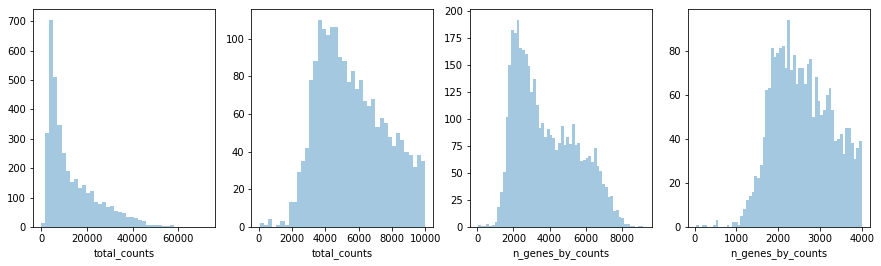

PDAC_242P1-H4A2


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


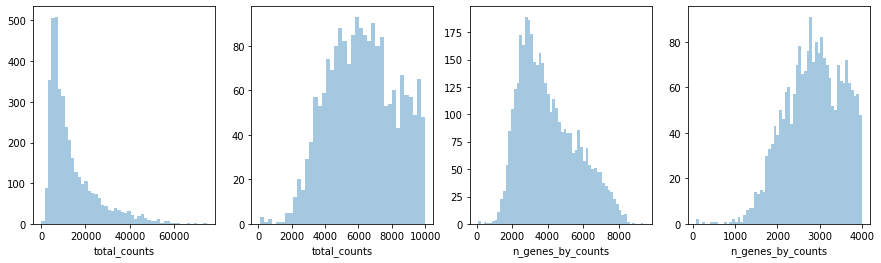

dict_keys(['PDAC_242P1-H1', 'PDAC_242P1-H2A2', 'PDAC_242P1-H3', 'PDAC_242P1-H4A2'])

In [7]:
sample_to_adata = {}
for i, fp in enumerate(fps):
    s = fp.split('/')[-3]
    print(s)
    a = sc.read_visium(fp.replace('/filtered_feature_bc_matrix.h5', ''))
    a.var_names_make_unique()
    a.var["mt"] = a.var_names.str.startswith("MT-")
    sc.pp.calculate_qc_metrics(a, qc_vars=["mt"], inplace=True)
    a.obs.index = [f'{s}_{x}' for x in a.obs.index]
    a.obs['sample_id'] = s
    a.obs['fov'] = str(i)
    sample_to_adata[s] = a

    fig, axs = plt.subplots(1, 4, figsize=(15, 4))
    sns.distplot(a.obs["total_counts"], kde=False, ax=axs[0])
    sns.distplot(a.obs["total_counts"][a.obs["total_counts"] < 10000], kde=False, bins=40, ax=axs[1])
    sns.distplot(a.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
    sns.distplot(a.obs["n_genes_by_counts"][a.obs["n_genes_by_counts"] < 4000], kde=False, bins=60, ax=axs[3])
    plt.show()

sample_to_adata.keys()

In [8]:
for s, a in sample_to_adata.items():
    print(a.shape)
    sc.pp.filter_cells(a, min_counts=1000)
    a = a[a.obs["pct_counts_mt"] < 20]
    
    sc.pp.normalize_total(a, target_sum=10e4)
    sc.pp.log1p(a)
    
    a.raw = a
    
    sample_to_adata[s] = a
    
    print(a.shape)

(3077, 36601)


/home/estorrs/.local/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


(3073, 36601)
(3130, 36601)
(3123, 36601)
(3880, 36601)
(3872, 36601)
(3923, 36601)
(3917, 36601)


In [9]:
def spot_to_neighbors(adata, n_neighbors=7, radius=400.):
    X = adata.obsm['spatial']
    nbrs = NearestNeighbors(algorithm='ball_tree').fit(X)
    
    g = nbrs.kneighbors_graph(X, n_neighbors=n_neighbors, )
#     g = nbrs.radius_neighbors_graph(X, radius=radius, )
    rows, cols, _ = scipy.sparse.find(g)
    
    spot_to_neighbhors = {x:[] for x in adata.obs.index.to_list()}
    for r, c in zip(rows, cols):
        cid = adata.obs.index[r]
        spot_to_neighbhors[cid].append(adata.obs.index[c])
    spot_to_neighbhors = {spot:[nbhr for nbhr in nbhrs if nbhr != spot]
                          for spot, nbhrs in spot_to_neighbhors.items()}
    return spot_to_neighbhors

In [10]:
for s, a in sample_to_adata.items():
    a.uns['spot_to_neighbors'] = spot_to_neighbors(a)

/miniconda/envs/SpiceMix/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'sample_id' as categorical
/miniconda/envs/SpiceMix/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'fov' as categorical
/miniconda/envs/SpiceMix/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering ca

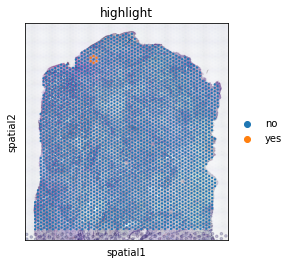

In [11]:
test = next(iter(sample_to_adata.values()))
test.obs['highlight'] = ['yes' if x in test.uns['spot_to_neighbors'][test.obs.index[100]] else 'no'
                      for x in test.obs.index]
sc.pl.spatial(test, color='highlight')

In [12]:
combined = anndata.concat(sample_to_adata.values())
combined.uns['spot_to_neighbors'] = {}
for s, a in sample_to_adata.items():
    combined.uns['spot_to_neighbors'].update(a.uns['spot_to_neighbors'])

combined

AnnData object with n_obs × n_vars = 13985 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'sample_id', 'fov', 'n_counts'
    uns: 'spot_to_neighbors'
    obsm: 'spatial'

In [13]:
# limit to genes with > 10% expression accross samples
combined.raw = combined
sc.pp.filter_genes(combined, min_counts=int(.1 * combined.shape[0]))
combined

AnnData object with n_obs × n_vars = 13985 × 12518
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'sample_id', 'fov', 'n_counts'
    var: 'n_counts'
    uns: 'spot_to_neighbors'
    obsm: 'spatial'

In [14]:
genes = combined.var.index.to_list()

In [105]:
for s, a in sample_to_adata.items():
    fov = a.obs['fov'][0]
    gene_table = a[:, genes].var[[]]
    gene_table.index.name = 'Gene'

    meta = a.obs[['array_row', 'array_col']]
    meta.columns = ['coor Y', 'coor X']

    exp = pd.DataFrame(data=a[:, genes].X.toarray(), columns=genes, index=a.obs.index)

    spot_to_index = {spot:i for i, spot in enumerate(a.obs.index)}
    edges = [[spot_to_index[spot1], spot_to_index[spot2]]
             for spot1, nbhrs in a.uns['spot_to_neighbors'].items()
             for spot2 in nbhrs]
    edges = pd.DataFrame(data=edges, columns=['Spot', 'Neighbor'])

    gene_table.to_csv(os.path.join(output_dir, f'genes_{fov}.txt'), sep='\t', index=True, header=False)
    meta.to_csv(os.path.join(output_dir, f'meta_{fov}.txt'), sep='\t', index=False, header=True)
    exp.to_csv(os.path.join(output_dir, f'expression_{fov}.txt'), sep='\t', index=False, header=False)
    edges.to_csv(os.path.join(output_dir, f'neighborhood_{fov}.txt'), sep='\t', index=False, header=False)

In [16]:
directory = os.path.join(output_dir, '..', 'input_adatas')
Path(directory).mkdir(parents=True, exist_ok=True)
for s, a in sample_to_adata.items():
    a.write_h5ad(os.path.join(directory, f'{s}.h5ad'))

/miniconda/envs/SpiceMix/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'sample_id' as categorical
/miniconda/envs/SpiceMix/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'fov' as categorical
/miniconda/envs/SpiceMix/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering ca